In [1]:
import logging
from nltk import word_tokenize
import pandas as pd
import numpy as np
import gc
import os
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score
from torch import optim
import torchtext
import random
import matplotlib.pyplot as plt
import copy, time


In [2]:
text = torchtext.data.Field(lower=True, batch_first=True, tokenize=word_tokenize)
qid = torchtext.data.Field()


In [3]:
start = time.time()
target = torchtext.data.Field(sequential=False, use_vocab=False, is_target=True)
train = torchtext.data.TabularDataset(path='./data/Quora/train.csv', format='csv',
                                      fields={'question_text': ('text',text),
                                              'target': ('target',target)})
test = torchtext.data.TabularDataset(path='./data/Quora/test.csv', format='csv',
                                     fields={'qid': ('qid', qid),
                                             'question_text': ('text', text)})
end = time.time()
print((end - start)/ 60)

0.34002894163131714


In [4]:
text.build_vocab(train, test, min_freq=3)
qid.build_vocab(test)
text.vocab.load_vectors(torchtext.vocab.
                        Vectors(r'C:\Users\Nikita\PycharmProjects\Sem_2\data\glove.6B.50d.txt'))

random.seed(42)
train, val = train.split(split_ratio=0.9, random_state=random.getstate())

In [5]:
batch_size = 64

In [6]:
train_iter = torchtext.data.BucketIterator(dataset=train,
                                               batch_size=batch_size,
                                               sort_key=lambda x: x.text.__len__(),
                                               shuffle=True,
                                               sort=False)
val_iter = torchtext.data.BucketIterator(dataset=val,
                                             batch_size=batch_size,
                                             sort_key=lambda x: x.text.__len__(),
                                             train=False,
                                             sort=False)

In [7]:
class SimpleLSTM(nn.Module):
    def __init__(self, pretrained_lm, padding_idx,  hidden_dim=128, lstm_layer=2, dropout=0.2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding.from_pretrained(pretrained_lm)
        self.embedding.padding_idx = padding_idx
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(input_size=self.embedding.embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=lstm_layer,)
        self.hidden2label = nn.Linear(hidden_dim * lstm_layer , 1)

    def forward(self, sents):
        x = self.embedding(sents)
        x = torch.transpose(x, dim0=1, dim1=0)
        lstm_out, (h_n, c_n) = self.lstm(x)
        cat = torch.cat([c_n[i, :, :] for i in range(c_n.shape[0])], dim=1)
        y = self.hidden2label(cat)
        return y

In [8]:
def training(num_epochs, model, loss_func, optimizer, train_iter, val_iter):
    
    step = 0
    train_record = []
    val_record = []
     
    for epoch in range(num_epochs):
        tr_loss = []
        for train_batch in iter(train_iter):
            step += 1
            model.train()
            x = train_batch.text.cuda()
            y = train_batch.target.type(torch.Tensor).cuda()
            model.zero_grad()
            pred = model.forward(x)
            loss = loss_function(pred.view(-1), y)
            tr_loss.append(loss.cpu().data.numpy())
            loss.backward()
            optimizer.step()
            
            if step % 100 == 0 :
                model.eval()
                model.zero_grad()
                val_loss = []
                for val_batch in iter(val_iter):
                    
                    val_x = val_batch.text.cuda()
                    val_y = val_batch.target.type(torch.Tensor).cuda()
                    val_pred = model.forward(val_x).view(-1)
                    val_loss.append(loss_function(val_pred, val_y).cpu().data.numpy())
                    
                val_record.append({'step': step, 'loss': np.mean(val_loss)})
                train_record.append({'step': step, 'loss':  np.mean(tr_loss)})

                print('epoch {:02} - step {:06} - train_loss {:.4f} - val_loss {:.4f} '.format(
                    epoch, step,  train_record[-1]['loss'], val_record[-1]['loss']))
    return train_record, val_record

In [9]:
LSTM_model = SimpleLSTM(text.vocab.vectors, lstm_layer=1, padding_idx=text.vocab.stoi[text.pad_token], 
                        hidden_dim=128).cuda()

In [10]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, LSTM_model.parameters()),
                    lr=0.001)

In [11]:
loss_function = nn.BCEWithLogitsLoss()

In [12]:
num_epochs = 10

In [13]:
start = time.time()

t_record, v_record = training(model=LSTM_model, num_epochs=num_epochs, 
         loss_func = loss_function, optimizer=optimizer, train_iter=train_iter,
        val_iter=val_iter)

end = time.time()
print((end - start)/ 60)

epoch 00 - step 000100 - train_loss 0.2893 - val_loss 0.2488 
epoch 00 - step 000200 - train_loss 0.2578 - val_loss 0.2404 
epoch 00 - step 000300 - train_loss 0.2463 - val_loss 0.2359 
epoch 00 - step 000400 - train_loss 0.2420 - val_loss 0.2499 
epoch 00 - step 000500 - train_loss 0.2403 - val_loss 0.2294 
epoch 00 - step 000600 - train_loss 0.2402 - val_loss 0.2514 
epoch 00 - step 000700 - train_loss 0.2390 - val_loss 0.2450 
epoch 00 - step 000800 - train_loss 0.2384 - val_loss 0.2443 
epoch 00 - step 000900 - train_loss 0.2371 - val_loss 0.2395 
epoch 00 - step 001000 - train_loss 0.2333 - val_loss 0.2229 
epoch 01 - step 001100 - train_loss 0.1966 - val_loss 0.1891 
epoch 01 - step 001200 - train_loss 0.1916 - val_loss 0.1813 
epoch 01 - step 001300 - train_loss 0.1858 - val_loss 0.1849 
epoch 01 - step 001400 - train_loss 0.1785 - val_loss 0.1738 
epoch 01 - step 001500 - train_loss 0.1733 - val_loss 0.1713 
epoch 01 - step 001600 - train_loss 0.1724 - val_loss 0.1720 
epoch 01

In [17]:
t = [ t_record[i]['loss']  for i in range(len(t_record))]
v = [ v_record[i]['loss']  for i in range(len(t_record))]
len(v), len(t)

(105, 105)

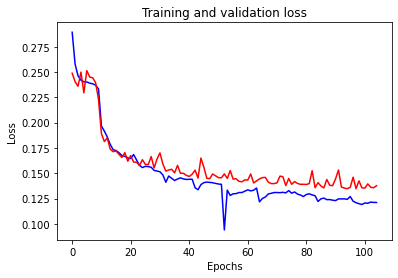

In [18]:
x = np.arange(0, len(t))
plt.plot(x, t, 'b', label='Training loss')
plt.plot(x, v, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [21]:
LSTM_model.eval()
val_pred = []
val_true = []
val_iter.init_epoch()
for val_batch in iter(val_iter):
    val_x = val_batch.text.cuda()
    val_true += val_batch.target.data.numpy().tolist()
    val_pred += torch.sigmoid(LSTM_model.forward(val_x).view(-1)).cpu().data.numpy().tolist()

In [22]:
tmp = [0,0,0] 
delta = 0
for tmp[0] in np.arange(0.1, 0.501, 0.01):
    tmp[1] = f1_score(val_true, np.array(val_pred)>tmp[0])
    if tmp[1] > tmp[2]:
        delta = tmp[0]
        tmp[2] = tmp[1]
print('best threshold is {:.4f} with F1 score: {:.4f}'.format(delta, tmp[2]))

best threshold is 0.3100 with F1 score: 0.6172
